In [1]:
#imports tools and constants definitions
import numpy as np
from astropy.io import ascii 
import matplotlib.pyplot as plt 
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [2]:
#convert column values to np.array
#numColumns = data.columns
#print(numColumns)
#for i in len(numColumns):
#    columns = []
#    columns.append(np.array[data[numColumns[i]]])

In [3]:
#reads the data and tests for correct input
data = ascii.read('Astr511HW1data.dat.txt',format='commented_header') #commented_head use this in jupyter notebooks
print(data[:10])
 ##    ra        dec   run     Ar      u      g      r      i      z  uErr  gErr  rErr  iErr  zErr    pmL    pmB    pmErr

    ra      dec    run   Ar    u     g   ... rErr iErr zErr  pmL   pmB   pmErr
--------- -------- ---- ---- ----- ----- ... ---- ---- ---- ----- ------ -----
 181.6122  27.5726 5087 0.05  16.4 15.24 ... 0.02 0.02 0.01  5.16  -1.45  2.72
181.61303  27.6077 5087 0.05 21.84 19.55 ... 0.02 0.02 0.02  5.48   4.73  3.16
181.61416 27.35956 5112 0.05 19.76 17.56 ... 0.02 0.03 0.03  3.14   7.92  2.79
 181.6164 27.82464 5112 0.06 21.73 20.63 ... 0.03 0.03 0.13 19.13  -1.08  5.08
181.62112 28.01623 5087 0.05 21.37 20.38 ... 0.03 0.03 0.09 -3.65   -8.0  4.91
181.62252 27.63987 5087 0.05 17.34 15.58 ... 0.02 0.02 0.01  9.74 -10.64  2.72
181.62469 27.32682 5112 0.05 21.63 20.52 ... 0.03 0.04 1.07  6.73 -25.39  5.13
181.62582 27.42162 5112 0.05 23.16 21.09 ... 0.02 0.03 0.04 35.17    7.8  4.18
181.63178 26.93836 5112 0.05 18.57 15.96 ... 0.02 0.02 0.02 15.96  -8.01  2.72
181.63364 27.24131 5087 0.06  20.9 18.78 ... 0.02 0.02 0.02  2.03  -5.43  2.96


In [4]:
#computes metallicity function [Bond et al. 2010]
def metallicity(x,y):
    """
    Calculates metallicity [Bond et al. 2010]
        
            Parameters:
                x( float array): u-g SDSS band
                y( float array): g-r SDSS band
            Returns:
                metallicity (float array): Fe/H
    """
    #defines best-fit coefficients given by Bond et al. in array type from A-J
    A=-13.13
    B= 14.09
    C= 28.04
    D= -5.51
    E= -5.90
    F= -58.68
    G= 9.14
    H= -20.61
    I= 0.0
    J= 58.20
    #creates empty array to allocate results 
    metallicityArray = np.empty(y.size)
    metallicityArray[:] = 0
    #loops through  data 
    for i in range (y.size):
        if(y[i] < 0.6 ):    
        #appends to resulting metallicity array and computes the formula. This seems very tricky but it's simple don't panick h
            metallicityArray[i] = A+B*x[i]+C*y[i]+D*x[i]*y[i]+E*(x[i]**2)+F*(y[i]**2)+G*((x[i])**2)*y[i]+H*x[i]*((y[i])**2)+I*((x[i])**3)+J*(y[i]**3)
        else:
            metallicityArray[i] = -0.6
    return metallicityArray
    # metallicityArray[i] = A + B*x[i]+ C*y[i] + D*x[i]*y[i] + E*pow(x,2) + F*pow(y,2)+G*pow(x,2)*y + H*pow(y,2)*x + I*pow(x,3)+J*pow(y,3)


In [5]:
#tests metallicity function
x = np.array(data['u'] - data['g'])
y = np.array(data['g'] - data['r'])
metas = metallicity(x,y)
print(metas)

[-0.8191296 -0.6       -0.6       ... -0.6       -0.6       -0.6      ]


In [6]:
#computes absolute magnitude using photometric parallax relationship [Ivezić et al. 2008]
def abs_mag(band):
    """
    Calculates absolute magnitudes [Bond et al. 2010]
        
            Parameters:
                band( float array): g -i SDSS band
            Returns:
                absolute magnitudes(float array)
    """
    #defines an empty array to return result
    absolute_magnitude = np.empty(band.size)
    #computes metallicity with previous function
    metas = metallicity(x,y)
    #loops through the arrays
    for i in range(band.size):
        mgn_metallicity = 4.50 -1.11*metas[i] -0.18*pow(metas[i],2)
        #A7
        mgn_band = -5.06  +14.32*band[i] - 12.97*pow(band[i],2) + 6.127*pow(band[i],3) - 1.267*pow(band[i],4) + 0.0967*pow(band[i],5)
        #A4
        absolute_magnitude[i] = mgn_band + mgn_metallicity
    return absolute_magnitude
    
    

In [7]:
#test abs_mag function
z = np.array(data['g'] - data['i'])
mag = abs_mag(z)
print(mag[:50])
#testingArray  = (mag[:50] -np.array(data['r'])[:50])/5
#print(np.power(10,testingArray))

[4.88853564 7.35863457 6.99674651 5.64485961 3.93777605 6.21245575
 4.16177266 8.80018053 7.81967066 7.13325661 6.6090974  7.15312504
 9.00008196 5.87101687 5.19660953 5.58187673 6.30386407 7.67323561
 5.60238331 6.51519194 5.35027913 6.61439034 6.16487668 5.30720682
 3.19556732 4.52877622 6.21245575 3.63096175 7.19319385 8.13587644
 4.6269505  8.76762222 4.86438559 8.54593156 5.95950349 5.2726
 5.48947639 7.92153682 4.85531136 6.39095648 8.89916384 9.172468
 8.00023676 5.33635662 4.64081984 6.32601057 5.20893682 5.40817644
 6.67260076 5.29597751]


In [8]:
#getting distances
def distance(absolutes,apparent):
    #creates an empty array to return 
    result = np.empty(absolutes.size)
    for i in range(absolutes.size):
        formula = np.empty(absolutes.size)
        formula[i] = (apparent[i] - absolutes[i])/5
        result = np.power(10,formula)/10
    return result
        

In [9]:
myArray = (np.array(data['r'])- mag)/5
distancesCool = np.power(10,myArray)
print(distancesCool*10) #this should be in parsecs and about the same distances since this is supposed to be in the same galaxy


[ 960.04783539 1615.37399051  836.85593009 ...  248.34974785  473.49750882
 1338.20802884]


In [10]:
myDistance = distance(mag[:50],np.array(data['r'])[:50])
print(myDistance)

[           inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf 1.18110345e+13
            inf 6.26331853e+01]


C:\Users\cosme\AppData\Local\Temp/ipykernel_14824/3604632652.py:8: RuntimeWarning: overflow encountered in power
  result = np.power(10,formula)/10


In [11]:
def volume_function(distance):
    #creates an empty array to return
    result = np.empty(distance.size)
    result[:] = 0
    for i in range(distance.size):
        result[i] = 4/3*np.pi*distance[i]**3
    return result
# volumes = 4/3*np.pi*distancesCool**3 [use for testing]


In [12]:
vol = volume_function(distancesCool)
print(vol)

[ 3706527.50785989 17656632.06363363  2454938.9879717  ...
    64162.27872095   444673.96671422 10038284.56430119]


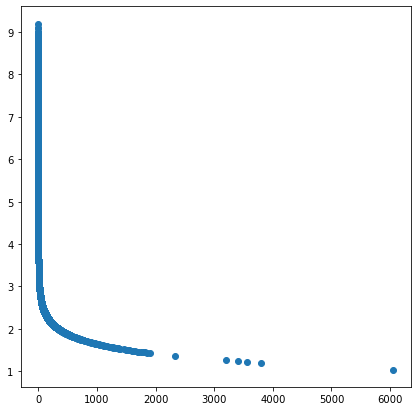

In [42]:
#calculates the average density 
densities_array = np.empty(data['ra'].size)
densities = data['ra'].size/vol
#plots the ln(density) vs distance
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(densities,np.log(distancesCool),'o')
#repeats for smaller chuncks of volumes

In [56]:
#Task #1
#defines an array with range 0.2 <(g-i)< 0.4 band
#counts number of elements that meet conditions
for i in range(y.size):
    ctr = 0
    if y[i] > 0.2 and y[i] < 0.4:
        ctr = ctr + 1

0
